In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve

### Generate dataset

In [2]:
label_scheme = 'labels_2'

lc_features = pd.read_csv('../processed_data/lc_features.csv')
gaia_features = pd.read_csv('../processed_data/gaia_features.csv')

# Drop the columns that are not needed
drop = gaia_features.columns.to_list()[1:16]
gaia_features.drop(drop, axis=1, inplace=True)

# Merge the two datasets
merged = pd.merge(lc_features, gaia_features, on=['oid_ztf'], how='inner')

# Limit to labels_2
dataset = merged[~merged[label_scheme].isnull()].reset_index(drop=True)

# Drop some columns
drop2 = ['FalseAlarm_prob_g','FalseAlarm_prob_r']
dataset.drop(drop2, axis=1, inplace=True)

# Handle some outliers
from outlier import outlier_thresholds_skewed, apply_thresholds
skewed_g = ['CAR_mean_g','CAR_sigma_g','Eta_e_g','Freq1_harmonics_amplitude_0_g', 'Freq1_harmonics_amplitude_1_g', 
                 'Freq1_harmonics_amplitude_2_g', 'Freq1_harmonics_amplitude_3_g','Freq2_harmonics_amplitude_0_g', 
                 'Freq2_harmonics_amplitude_1_g', 'Freq2_harmonics_amplitude_2_g', 'Freq2_harmonics_amplitude_3_g',
                 'Freq3_harmonics_amplitude_0_g', 'Freq3_harmonics_amplitude_1_g', 'Freq3_harmonics_amplitude_2_g', 
                 'Freq3_harmonics_amplitude_3_g','LinearTrend_g', 'MaxSlope_g','PeriodLS_g', 'Period_fit_g','SlottedA_length_g']

skewed_r = ['CAR_mean_r','CAR_sigma_r','Eta_e_r','Freq1_harmonics_amplitude_0_r', 'Freq1_harmonics_amplitude_1_r',
            'Freq1_harmonics_amplitude_2_r', 'Freq1_harmonics_amplitude_3_r','Freq2_harmonics_amplitude_0_r',
            'Freq2_harmonics_amplitude_1_r', 'Freq2_harmonics_amplitude_2_r', 'Freq2_harmonics_amplitude_3_r',
            'Freq3_harmonics_amplitude_0_r', 'Freq3_harmonics_amplitude_1_r', 'Freq3_harmonics_amplitude_2_r',
            'Freq3_harmonics_amplitude_3_r','LinearTrend_r', 'MaxSlope_r','PeriodLS_r', 'Period_fit_r','SlottedA_length_r']

ots = outlier_thresholds_skewed(dataset, skewed_g+skewed_r, iqr_threshold=2, upper_limit=None, lower_limit=0)
dataset = apply_thresholds(dataset, skewed_g+skewed_r, ots)

pd.options.display.max_columns = None
pd.options.display.max_rows = 10




In [3]:
from sklearn.preprocessing import LabelEncoder

missingness_threshold = 0.5

X = dataset.iloc[:,16:]
y_names = dataset[label_scheme]
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)

# Drop columns with missingness > 0.5
missingness = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False)
missing_high = missingness[missingness>missingness_threshold].index.to_list()
print(f'\nColumns removed for missingness fraction of >{missingness_threshold}\n{missing_high}\n')
X = X.drop(missing_high, axis=1)

# Save feature column names.
X_cols = X.columns.to_list()
# Replace np.inf with np.nan
for col in X_cols:
    X.loc[(X[col]==np.inf)|(X[col]==-np.inf), col] = np.nan

X.shape


Columns removed for missingness fraction of >0.5
['Eta_color']



(1439, 252)

In [4]:
# Train, test, split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# Print the labelling scheme with associated value counts.
pd.options.display.max_rows = None
print('Labelling scheme:')
print(dataset[label_scheme].value_counts())


Labelling scheme:
dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

# Classifier to use.
classifier = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1, random_state=1)
classifierNm= 'RF'

# Subclass ColumnTransformer to return a Dataframe with columns instead of just an array (what is usually returned)
# This is useful after imputation.
class ColumnTransformerPandas(ColumnTransformer):
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)
    
    def fit_transform(self, X, y=None):
        self.columns = X.columns
        return pd.DataFrame(super().fit_transform(X, y), columns=self.columns)


# Use the above subclasses functions to individually handle the processing of columns.
impute_simple = ColumnTransformerPandas([
    ('imputer', SimpleImputer(strategy='mean'), X_cols)],
    remainder='passthrough')

impute_KNN = ColumnTransformerPandas([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance'), X_cols)],
    remainder='passthrough')

normalise = ColumnTransformerPandas([
    ('normalise', StandardScaler(), X_cols)], 
    remainder='passthrough')

size = 390

print(enc.transform(['dwarf_nova_SU_UMa'])[0])
# undersampling dictionary.
class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:size}
            #   enc.transform(['dwarf_nova_Z_Cam'])[0]:100,
            #   enc.transform(['dwarf_nova_U_Gem'])[0]:100,
            #   enc.transform(['nova_like_VY_Scl'])[0]:100,
            #   enc.transform(['polar'])[0]:100,
            #   enc.transform(['nova_like'])[0]:100,
            #   enc.transform(['nova'])[0]:100,
            #   enc.transform(['int_polar'])[0]:100,
            #   enc.transform(['AMCVn'])[0]:100
            #   }


class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:size,
                 enc.transform(['dwarf_nova_Z_Cam'])[0]:size,
                 enc.transform(['dwarf_nova_U_Gem'])[0]:size,
                 enc.transform(['nova_like_VY_Scl'])[0]:size,
                 enc.transform(['polar'])[0]:size,
                 enc.transform(['nova_like'])[0]:size,
                 enc.transform(['nova'])[0]:size,
                 enc.transform(['int_polar'])[0]:size,
                 enc.transform(['AMCVn'])[0]:size
                }


undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=1)
oversample = ADASYN(sampling_strategy=class_dist_os, n_neighbors=5,random_state=1)

# Generate a pipeline to perform the column transformations sequentially.
pipe = Pipeline([
    ('preimpnorm', normalise),
    ('impute', impute_KNN),
    ('us', undersample),
    ('os', oversample),
    ('normalise', None),
    ('clf', classifier)
])

# pipe0 = Pipeline([
#     ('preimpnorm', normalise),
#     ('impute', impute_KNN),
#     ('os', oversample)
# ])

# Lets display the pipeline to see the processes.
# with display='diagram', simply use display() to see the diagram
from sklearn import set_config
set_config(display='diagram')
display(pipe)
# if desired, set display back to the default
# set_config(display='text')


# # Get parameters of everything in the pipeline, including ColumnTransformer and classifier functions.
# pipe.get_params()


1


Pipeline(steps=[('preimpnorm',
                 ColumnTransformerPandas(remainder='passthrough',
                                         transformers=[('normalise',
                                                        StandardScaler(),
                                                        ['Amplitude_g',
                                                         'AndersonDarling_g',
                                                         'Autocor_length_g',
                                                         'Beyond1Std_g',
                                                         'CAR_mean_g',
                                                         'CAR_sigma_g',
                                                         'CAR_tau_g', 'Con_g',
                                                         'Eta_e_g',
                                                         'FluxPercentileRatioMid20_g',
                                                         'FluxPercentileRatioMid35_g',
                                                         'FluxPercentileRatioMid50_g',
                                                         'FluxPercentile...
                                                         'Freq3_harmonics_amplitude_0_g',
                                                         'Freq3_harmonics_amplitude_1_g', ...])])),
                ('us',
                 RandomUnderSampler(random_state=1,
                                    sampling_strategy={1: 390})),
                ('os',
                 ADASYN(random_state=1,
                        sampling_strategy={0: 390, 1: 390, 2: 390, 3: 390,
                                           4: 390, 5: 390, 6: 390, 7: 390,
                                           8: 390})),
                ('normalise', None),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_jobs=-1, random_state=1))])

### Validation curves

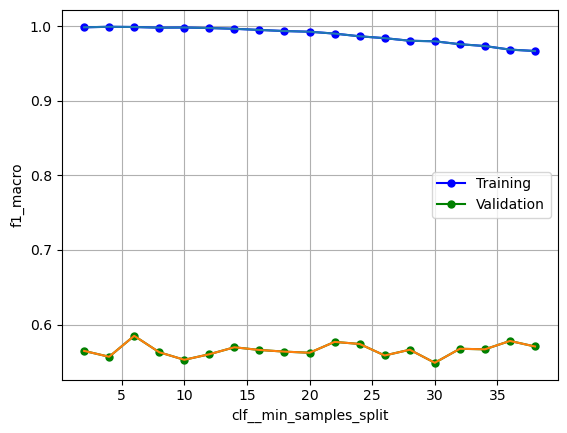

In [11]:
from matplotlib import pyplot as plt

param_name = 'clf__min_samples_split'
param_range = list(range(2, 40,2))

train_scoreNum, test_scoreNum = validation_curve(
                                estimator=pipe,
                                X=X_train, 
                                y=y_train, 
                                param_name = param_name, 
                                param_range = param_range,
                                cv = 10,
                                scoring='f1_macro')

train_mean = np.mean(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)

# Plot the model scores (accuracy) against the paramater range

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation')
plt.legend()
plt.plot(param_range, train_mean)
plt.plot(param_range, test_mean)
plt.xlabel(param_name)
plt.ylabel('f1_macro')
plt.grid()
plt.show()

In [8]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['clf__max_depth'] = [14]
param1['clf__max_features'] = [0.4]
param1['clf__min_samples_split'] = [6]
param1['clf__n_estimators'] = [500]
params = [param1]


# Select grid search cv folds
n_folds = 10


# Scorers
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision_score': make_scorer(precision_score, average='macro', zero_division=True), # weighted precision
    'recall_score': make_scorer(recall_score, average='macro'), # weighted recall
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=True) #'f1_weighted': 'f1_weighted'
}


# Compile GridSearchCV settings.
refit = 'f1_macro'
grid = RandomizedSearchCV(pipe, params, scoring=scoring, refit=refit, cv=n_folds, n_iter=50, verbose=2)


# Fit different models on training data
grid.fit(X_train, y_train)

# Place results in a dataframe.
cv_results = pd.DataFrame(grid.cv_results_)
print(f'Number of fits: {cv_results.shape[0]}')

/Users/aridmist/opt/anaconda3/envs/phd/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  23.0s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  18.7s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  20.1s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  20.4s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  20.6s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  21.0s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total time=  20.7s
[CV] END clf__max_depth=14, clf__max_features=0.4, clf__min_samples_split=6, clf__n_estimators=500; total 

In [9]:
def plot_roc(y_train, y_test, y_prob, label_encoder, path):

    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import roc_curve, auc, RocCurveDisplay
    from itertools import cycle
    import matplotlib.pyplot as plt
    import numpy as np


    # One hot encode the class labels
    # y_onehot_test.shape (n_samples, n_classes)
    # we use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion. 
    # This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test) 


    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()


    # Compute micro-average ROC curve and ROC area
    # ROC curve using micro-averaged OvR
    # Micro-averaging aggregates the contributions from all the classes (using np.ravel) to compute the average metrics as follows:
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    n_classes = label_encoder.classes_.shape[0]

    # Store the fpr, tpr and roc_auc for each class vs the remaining classes.
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    # Threshold values of probability
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    # Construct plots
    fig, ax = plt.subplots(figsize=(8, 8))



    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["red", "orange", "grey", "lightgreen", "green", "cyan", "blue", "indigo", "violet", "darkgrey"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{label_encoder.inverse_transform(np.unique(y_train))[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curves \nOne-vs-Rest multiclass")
    plt.legend()
    plt.savefig(path, format='pdf', bbox_inches='tight')
    plt.show()

# Plot feature importances
def plot_feature_importance(importance,names,model_type, path, top_n=20):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[0:top_n,:]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig(path, format='pdf', bbox_inches='tight')


{'clf__n_estimators': 500, 'clf__min_samples_split': 6, 'clf__max_features': 0.4, 'clf__max_depth': 14}


/var/folders/yq/zm05jz7s71gcr7b1vcn469p00000gq/T/ipykernel_12571/3963803727.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = np.transpose( np.transpose(cm) / cm.astype(np.float).sum(axis=0) )


                   precision  recall  f1-score  support
AMCVn                   0.41    0.50      0.45       14
dwarf_nova_SU_UMa       0.91    0.80      0.85      189
dwarf_nova_U_Gem        0.51    0.66      0.57       35
dwarf_nova_Z_Cam        0.69    0.63      0.66       52
int_polar               0.20    0.13      0.16       15
nova                    0.47    0.57      0.52       14
nova_like               0.56    0.65      0.60       43
nova_like_VY_Scl        0.68    0.75      0.71       36
polar                   0.62    0.71      0.66       34
accuracy                0.70    0.70      0.70        0
macro avg               0.56    0.60      0.58      432
weighted avg            0.72    0.70      0.71      432


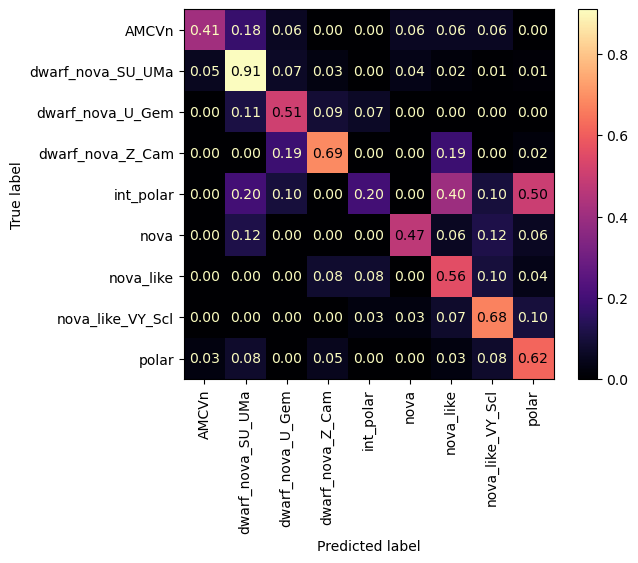

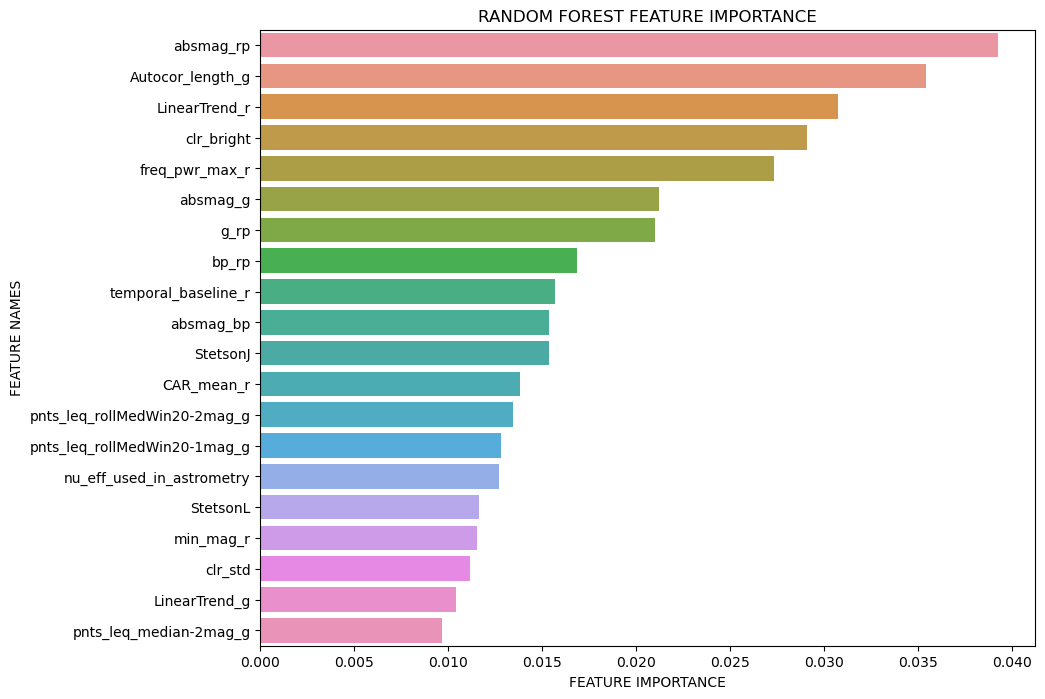

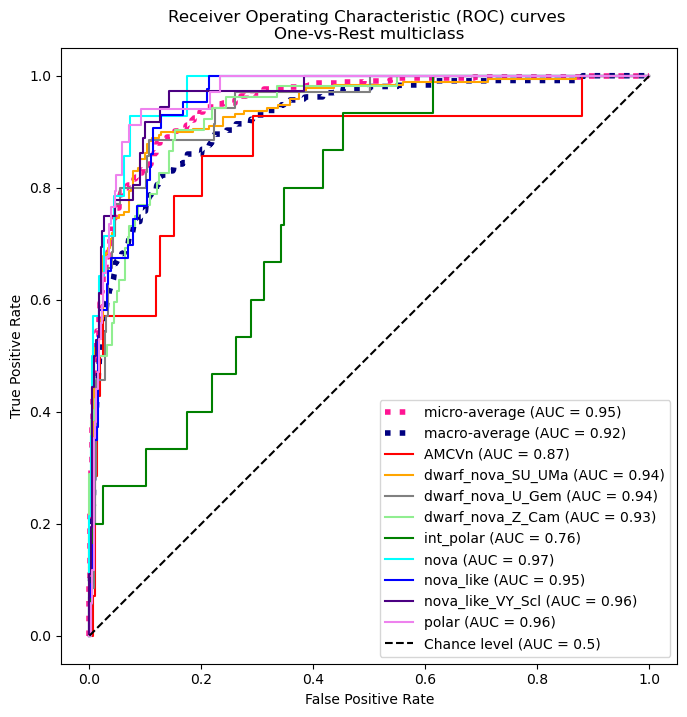

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

# Store best parameters and best model in variables.
best_params = grid.best_params_
best_model = grid.best_estimator_
print(best_params)


# Collect unique class labels in order of y_test.
class_labels = enc.inverse_transform(np.unique(y_test))


# Make predictions and gather probabilities for applying model to test set.
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize=None)
cm = np.transpose( np.transpose(cm) / cm.astype(np.float).sum(axis=0) )
# cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(xticks_rotation='vertical', cmap='magma', values_format='.2f')
disp.figure_.savefig(f'../results/cm_norm.pdf', format='pdf', bbox_inches='tight')



# Plot roc one vs rest curves
# plot_roc(y_train, y_test, y_prob, enc, path=f'class_balance/roc_{refit}_{classifierNm}_{label_scheme}.pdf')


# Print and save the classification report
cr = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
print(cr_df)


feature_importance_scores = best_model.named_steps['clf'].feature_importances_
plot_feature_importance(importance=feature_importance_scores, 
                        names=X_cols, model_type='RANDOM FOREST', top_n=20, path=f'../results/feature_importance.pdf')

plot_roc(y_train, y_test, y_prob, enc, path=f'../results/roc_curve.pdf')

In [84]:
# save the model using pickle
import pickle
pickle.dump(best_model, open(f'../results/rfmodel.pkl', 'wb'))
